### Description

#### Evaluates a number of estimators to construct the Voting Regressor meta-estimator with weights such that the mean squared error of the combined predictions of the estimators is minimized.

#### version: 2.0

#### TODO:


### Done:
- prune features
- full db integration
- finalize estimator selection
- estimator comp. df
- finalize 'fine tuning'
- save final estimators
- save final voting regressor
- plot results
- general file cleanup
- remove unused imports

In [1]:
# Import Dependencies
import pandas as pd
import numpy as np
import joblib

# Plots as needed
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.preprocessing import RobustScaler

# Data split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

# Model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ARDRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import HuberRegressor


# Model Validation and Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from scipy import stats

# MSE minimization
from sklearn.metrics import mean_squared_error
from scipy import optimize

# DB interface
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from config import db_password

## Interface with Database and create DataFrames

In [6]:
# Construct db string
user = 'postgres'
host = 'housing-prices.ch2ctomvepex.us-east-1.rds.amazonaws.com'
name = 'housing-prices'

db_string = f'postgresql://{user}:{db_password}@{host}/{name}'

In [7]:
# Create Connection Engine

engine = create_engine(db_string)

In [8]:
# map to Base to extract metadata
Base = automap_base()
Base.prepare(engine, reflect=True)

In [9]:
# List of tables corresponding to cities
table_names = []
city_list = ['austin','boston','sanfran','chandler','chicago','houston','la','pittsburgh','spokane']

# Group by city population
# To generalize, pop groups can be calc. based on population of known cities in groups.
low_list = ['chandler', 'pittsburgh', 'spokane']
mid_list = ['austin', 'boston', 'sf']
high_list = ['chicago', 'la', 'houston']

for k in Base.metadata.tables.keys():
    if k in city_list:
        table_names.append(k)

print(table_names)

['austin', 'sanfran', 'la', 'boston', 'chandler', 'pittsburgh', 'houston', 'spokane', 'chicago']


In [10]:
# Create df from comb. of all city tables

def city_df(eng,city_tables,lowpop_list=[],midpop_list=[],highpop_list=[]):
    
    all_pop = pd.DataFrame()
    
    for city in city_tables:
        
        if city in lowpop_list:
            
            # Create temp city df
            city = pd.read_sql_table(city, eng)
            
            # Add class col
            city['pop_class'] = 1
            
            # add to all_pop
            all_pop = pd.concat([all_pop,city])
            
        elif city in midpop_list:
            
            # Create temp city df
            city = pd.read_sql_table(city, eng)
            
            # Add class col
            city['pop_class'] = 2
            
            # add to all_pop
            all_pop = pd.concat([all_pop,city])
            
        elif city in highpop_list:
            
            # Create temp city df
            city = pd.read_sql_table(city, eng)
            
            # Add class col
            city['pop_class'] = 3
            
            # add to all_pop
            all_pop = pd.concat([all_pop,city])
               
    return all_pop

In [11]:
all_pop = city_df(eng=engine,city_tables=table_names,lowpop_list=low_list,
                  midpop_list=mid_list,highpop_list=high_list)
all_pop.head()

,price,bedroom,sqft,bathroom,amenity_count,cityid,pop_class
0,1191,1,600.0,1.0,5,1,2
1,1425,1,526.0,1.0,5,1,2
2,1266,1,578.0,1.0,5,1,2
3,1144,1,351.0,1.0,8,1,2
4,1775,4,1236.0,2.0,8,1,2


In [12]:
# Write to csv to prevent constant db calls
all_pop.to_csv('all_pop.csv',index=False)

In [19]:
# df from csv if needed
all_pop = pd.read_csv('all_pop.csv')

## Examine data

In [20]:
all_pop.describe()

,price,bedroom,sqft,bathroom,amenity_count,cityid,pop_class
count,4481.000000,4481.000000,4481.000000,4481.000000,4481.000000,4481.000000,4481.000000
mean,1842.516849,1.674403,939.883731,1.462174,5.571301,5.198393,1.950904
std,935.202674,0.942777,494.403762,0.633749,1.864343,2.632753,0.867467
min,225.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,1300.000000,1.000000,680.000000,1.000000,4.000000,3.000000,1.000000
50%,1653.000000,2.000000,875.000000,1.000000,6.000000,5.000000,2.000000
75%,2201.000000,2.000000,1114.000000,2.000000,7.000000,7.000000,3.000000
max,20000.000000,8.000000,15492.000000,5.000000,11.000000,9.000000,3.000000


In [21]:
# Check dtypes
all_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4481 entries, 0 to 4480
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4481 non-null   int64  
 1   bedroom        4481 non-null   int64  
 2   sqft           4481 non-null   float64
 3   bathroom       4481 non-null   float64
 4   amenity_count  4481 non-null   int64  
 5   cityid         4481 non-null   int64  
 6   pop_class      4481 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 245.2 KB


In [22]:
all_t = all_pop.copy()

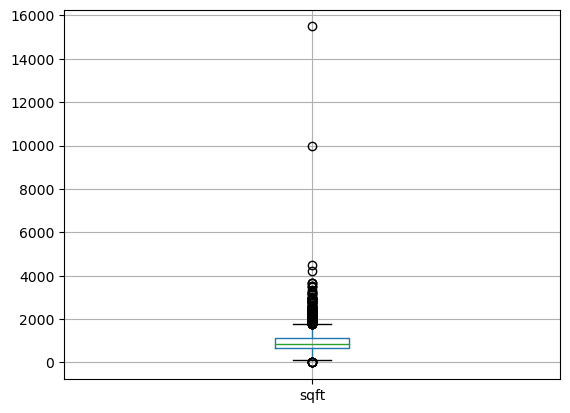

In [23]:
# Dist of num ft 'sqft' -> appears many outside 1.5*IQR
all_t.boxplot(column='sqft')
plt.savefig('figs/sqft')
plt.show()

In [24]:
# Calc iqr of sqft and upper/lower bounds
sqft_iqr = all_t.sqft.quantile(.75)-all_t.sqft.quantile(.25)
upper = 1.5*sqft_iqr + all_t.sqft.quantile(.75)
lower =  all_t.sqft.quantile(.25) - 1.5*sqft_iqr
print(lower)
print(upper)

29.0
1765.0


In [25]:
all_t.drop(all_t[all_t.sqft > upper].index, inplace=True)

## Split Train and Test Data

In [26]:
# Before examination, split so that the test set remains unobserved

# Split using SSS to incorporate data from each of the 3 groups in test and train sets.
split = StratifiedShuffleSplit(n_splits=10,test_size=0.2, random_state=42)

for train_index, test_index in split.split(all_t, all_t['cityid']):
    strat_train_set = all_t.iloc[train_index]
    strat_test_set = all_t.iloc[test_index]

In [27]:
# Create a new df that is a copy of the training set to preserve it.
all_train = strat_train_set.copy()

# Repeat for test set
all_test = strat_test_set.copy()

# Show first 5 rows of training set
all_train.head()

,price,bedroom,sqft,bathroom,amenity_count,cityid,pop_class
3735,1458,2,875.0,1.0,7,9,1
1321,1725,2,822.0,2.0,6,3,3
1141,3070,1,680.0,1.0,7,3,3
3375,1695,4,1687.0,4.0,5,7,3
3631,1145,2,928.0,1.0,6,9,1


In [9]:
# Compare Train Test Split
train_set,test_set = train_test_split(all_t, test_size=0.2, random_state=42)

In [10]:
# df for comparison of test sets
split_comp = pd.DataFrame()
split_comp['Overall'] = all_t.cityid.value_counts() / len(all_t.cityid)
split_comp['Strat_City'] = all_test.cityid.value_counts() / len(all_test.cityid)
split_comp['Random'] = test_set.cityid.value_counts() / len(test_set.cityid)
split_comp['Random %Error'] = ((split_comp.Random - split_comp.Overall) / split_comp.Overall)*100
split_comp['Strat_City %Error'] = ((split_comp.Strat_City - split_comp.Overall) / split_comp.Overall)*100
split_comp

,Overall,Strat_City,Random,Random %Error,Strat_City %Error
5,0.162541,0.162194,0.163361,0.504299,-0.213589
3,0.154601,0.155193,0.166861,7.930425,0.382843
9,0.152032,0.151692,0.140023,-7.898628,-0.223514
1,0.149229,0.149358,0.162194,8.687546,0.086373
7,0.112331,0.112019,0.086348,-23.130778,-0.277766
8,0.096450,0.096849,0.091015,-5.635120,0.413911
4,0.091079,0.091015,0.107351,17.866140,-0.070012
6,0.081738,0.081680,0.082847,1.357560,-0.070012


#### Stratified Shuffle Split demonstrates better representation of the population groupings

In [18]:
# Drop columns not used in analysis
# all_train.drop(columns=['cityid'],axis=1,inplace=True)
# all_test.drop(columns=['cityid'],axis=1,inplace=True)

### Preprocess Finalized Feature Set

In [28]:
# Remove target

X_train = all_train.drop(columns='price').values
y_train = all_train.price.values

X_test = all_test.drop(columns='price').values
y_test = all_test.price.values

In [29]:
# Scale using RobustScaler due to spread

rs = RobustScaler()

robust = rs.fit(X_train)

X_train_scaled = robust.transform(X_train)

X_test_scaled = robust.transform(X_test)

## Estimator Construction

In [30]:
# Create fn to out scores from cross_val_score to select estimators

def score_info(scores):
    MSE = -scores
    confidence = 0.95
    con_int= stats.t.interval(
    confidence,
    len(MSE)-1,
    loc=MSE.mean(),
    scale=stats.sem(MSE))
    
    print(f'Mean: {MSE.mean()}')
    print(f'STD: {MSE.std()}')
    print(f'Conf. Interval: {con_int}')
    return [MSE.mean(), MSE.std(), con_int[0], con_int[1]]

In [31]:
# Gradient Boosting Regressor

gbr_cvs = cross_val_score(GradientBoostingRegressor(random_state=42),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

gbr_score = score_info(gbr_cvs)

Mean: 192768.445478754
STD: 98055.04052027279
Conf. Interval: (136561.49656503668, 248975.39439247132)


In [32]:
# Random Forest Regressor

rfr_cvs = cross_val_score(RandomForestRegressor(random_state=42),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

rfr_score =score_info(rfr_cvs)

Mean: 178951.96933109735
STD: 99205.62627576942
Conf. Interval: (122085.4835446511, 235818.4551175436)


In [33]:
# Lasso

lasso_cvs = cross_val_score(LassoCV(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

lasso_score=score_info(lasso_cvs)

Mean: 396269.8068209221
STD: 125530.87123959343
Conf. Interval: (324313.20745161694, 468226.4061902273)


In [34]:
# Ridge

ridge_cvs = cross_val_score(RidgeCV(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ridge_score=score_info(ridge_cvs)

Mean: 396272.3676217422
STD: 125697.61987619313
Conf. Interval: (324220.1848734586, 468324.5503700258)


In [35]:
# Adaboost

ada_cvs = cross_val_score(AdaBoostRegressor(random_state=42),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ada_score=score_info(ada_cvs)

Mean: 338833.21971725486
STD: 94007.46300271043
Conf. Interval: (284946.4165252345, 392720.0229092752)


In [36]:
#ARDRegression

ard_cvs = cross_val_score(ARDRegression(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ard_score=score_info(ard_cvs)

Mean: 396646.5982446302
STD: 125447.82675455103
Conf. Interval: (324737.60149833735, 468555.59499092307)


In [37]:
# SVM with polynomial kernel

svp_cvs = cross_val_score(SVR(kernel='poly'),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svp_score = score_info(svp_cvs)

Mean: 570041.9499027763
STD: 160546.71471055187
Conf. Interval: (478013.6263803821, 662070.2734251705)


In [38]:
svl_cvs = cross_val_score(SVR(kernel='linear'),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svl_score = score_info(svl_cvs)

Mean: 462157.4544506695
STD: 140561.1143673481
Conf. Interval: (381585.2438577088, 542729.6650436302)


In [39]:
svr_cvs = cross_val_score(SVR(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svr_score = score_info(svr_cvs)

Mean: 573281.4550864247
STD: 154275.82160258602
Conf. Interval: (484847.72258854745, 661715.1875843019)


In [40]:
svs_cvs = cross_val_score(SVR(kernel='sigmoid'),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svs_score = score_info(svs_cvs)

Mean: 527396.7926898266
STD: 147632.82143198626
Conf. Interval: (442770.9498143652, 612022.6355652879)


In [41]:
# K nearest regression

knn_cvs = cross_val_score(KNeighborsRegressor(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

knn_score = score_info(knn_cvs)

Mean: 214419.04048259658
STD: 115778.75044362924
Conf. Interval: (148052.53574249952, 280785.54522269365)


In [42]:
bag_cvs = cross_val_score(BaggingRegressor(random_state=42),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

bag_score= score_info(bag_cvs)

Mean: 179767.13632465122
STD: 89830.26225074059
Conf. Interval: (128274.78127137569, 231259.49137792675)


In [43]:
hbr_cvs = cross_val_score(HuberRegressor(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

huber_score = score_info(hbr_cvs)

Mean: 406410.68052088656
STD: 128822.27247275932
Conf. Interval: (332567.38955484645, 480253.97148692666)


In [44]:
mod_type = ['Tree','Tree','Lin','Lin','Tree','Lin','Poly','Lin',
                       'RBF','Logistic','Cluster','Tree','Lin']
est_pre = pd.DataFrame([gbr_score,rfr_score,lasso_score,ridge_score,
                       ada_score,ard_score,svp_score,svl_score,
                        svr_score,svs_score,knn_score,bag_score,huber_score],
                       columns=['Mean MSE','Stdev MSE','CI Low','CI High'],
                       index=['GBR','RFR','Lasso','Ridge','AdaB','ARD','SVR(Poly)',
                              'SVR(rbf)','SVR(linear)','SVR(sigmoid)','Knearest',
                             'Bagging(tree)','Huber'])
est_pre['Model_Type'] = mod_type

In [46]:
est_pre.sort_values(by=['Mean MSE','Stdev MSE'])

,Mean MSE,Stdev MSE,CI Low,CI High,Model_Type
RFR,326005.263886,72901.130050,284216.998125,367793.529647,Tree
Bagging(tree),344931.802745,79618.698221,299292.903615,390570.701875,Tree
GBR,355769.360001,52978.999002,325400.825404,386137.894597,Tree
Knearest,373307.631419,68298.931653,334157.430247,412457.832591,Cluster
ARD,445986.230549,70177.433606,405759.237580,486213.223518,Lin
Lasso,446691.076829,69964.754770,406585.995273,486796.158386,Lin
Ridge,447200.476119,70046.352475,407048.621260,487352.330978,Lin
Huber,453606.952198,73403.135812,411530.927521,495682.976876,Lin
AdaB,507996.308963,72769.345784,466283.584362,549709.033564,Tree
SVR(rbf),523632.538341,76202.801618,479951.693839,567313.382843,Lin


#### Best 8 Models by MSE
- RFR (Tree)
- Bagging (Tree)
- GBR (Tree)
- Knearest (cluster)
- ARD (lin)
- Lasso (lin)
- Ridge (lin)
- Huber (lin)

#### Not significant variation in model type as desired

## Estimator Tuning

In [45]:
def mod_imp(model):
    scores = cross_val_score(model,X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)
    
    MSE = -scores
    confidence = 0.95
    con_int= stats.t.interval(
    confidence,
    len(MSE)-1,
    loc=MSE.mean(),
    scale=stats.sem(MSE))
    
    print(f'Mean: {MSE.mean()}')
    print(f'STD: {MSE.std()}')
    print(f'Conf. Interval: {con_int}')
    return [MSE.mean(), MSE.std(), con_int[0], con_int[1]]

In [46]:
# GBR

model = GradientBoostingRegressor()


mod_params = {
    'learning_rate': np.arange(.25,.35,.01),
    'n_estimators': np.arange(8,14),
    'subsample': np.arange(.93,.97,.005),
    'max_depth': np.arange(7,12),
    'random_state': [42],
    'max_features': ['sqrt'],
    'alpha': [1e-30]
}


    
model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
gbr = model_cv.best_estimator_

gbr_imp = mod_imp(gbr)

Fitting 15 folds for each of 2400 candidates, totalling 36000 fits
Mean: 175234.0814633973
STD: 100732.74122712137
Conf. Interval: (117492.2253583975, 232975.93756839712)


In [47]:
# Save Tuned Model
# joblib.dump(gbr,'mod_params/gbr.pkl')

In [48]:
# RFR

model = RandomForestRegressor()


mod_params = {
    'n_estimators': np.arange(20,40),
    'random_state': [42],
    'max_features': ['sqrt']
}

    
model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
rfr = model_cv.best_estimator_

rfr_imp = mod_imp(rfr)

Fitting 15 folds for each of 20 candidates, totalling 300 fits
Mean: 174295.91460704667
STD: 109491.96089591454
Conf. Interval: (111533.11302249145, 237058.71619160188)


In [49]:
# joblib.dump(rfr,'mod_params/rfr.pkl')

In [50]:
# Bagging

model = BaggingRegressor(random_state=42,n_jobs=-1)


mod_params = {
    'n_estimators': np.arange(1,50)
}

    
model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
bag = model_cv.best_estimator_

bag_imp = mod_imp(bag)

Fitting 15 folds for each of 49 candidates, totalling 735 fits
Mean: 179767.13632465122
STD: 89830.26225074059
Conf. Interval: (128274.78127137569, 231259.49137792675)


In [51]:
# joblib.dump(bag,'mod_params/bag.pkl')

In [52]:
# ARD

model = ARDRegression(n_iter=1000)


mod_params = {
    'alpha_1': [1e-50,1e-25],
    'alpha_2': [1e-50],
    'lambda_1': [1e-50],
    'lambda_2': [1e-50]
}


model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
ard = model_cv.best_estimator_

ard_imp = mod_imp(ard)

Fitting 15 folds for each of 2 candidates, totalling 30 fits
Mean: 396646.6242794903
STD: 125447.84014183063
Conf. Interval: (324737.61985936307, 468555.6286996176)


In [53]:
# joblib.dump(ard,'mod_params/ard.pkl')

In [54]:
lasso = LassoCV(n_alphas=1000,max_iter=5000, cv=15,n_jobs=-1,
               random_state=42)
lasso_imp = mod_imp(lasso)

Mean: 396269.5187692764
STD: 125531.02956916273
Conf. Interval: (324312.8286425561, 468226.2088959967)


In [55]:
# joblib.dump(lasso,'mod_params/lasso.pkl')

In [56]:
ridge = RidgeCV(alphas=[1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2],cv=15)
ridge_imp = mod_imp(ridge)

Mean: 396272.3676217459
STD: 125697.61987620303
Conf. Interval: (324220.18487345666, 468324.55037003517)


In [57]:
# joblib.dump(ridge,'mod_params/ridge.pkl')

In [58]:
# KNN

model = KNeighborsRegressor(n_jobs=-1)


mod_params = {
    'n_neighbors': np.arange(10,40,1),
    'weights': ['distance'],
    'p': [1]
    
}


model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
knn = model_cv.best_estimator_

knn_imp = mod_imp(knn)

Fitting 15 folds for each of 30 candidates, totalling 450 fits
Mean: 184614.8126363242
STD: 104862.27286689311
Conf. Interval: (124505.8332026033, 244723.7920700451)


In [59]:
# joblib.dump(knn,'mod_params/knn.pkl')

In [60]:
# Huber

model = HuberRegressor(max_iter=1000)


mod_params = {
    'epsilon': np.arange(10.5,11.5,.001),
    'alpha': [.01]
    
}


model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
huber = model_cv.best_estimator_

huber_imp = mod_imp(huber)

Fitting 15 folds for each of 1000 candidates, totalling 15000 fits
Mean: 396264.8988529539
STD: 125676.62826536872
Conf. Interval: (324224.74888127175, 468305.0488246361)


In [61]:
# joblib.dump(huber,'mod_params/huber.pkl')

In [62]:
est_post = pd.DataFrame([gbr_imp,rfr_imp,bag_imp,ard_imp,lasso_imp,ridge_imp,
                       knn_imp,huber_imp],
                       columns=['Mean MSE','Stdev MSE','CI Low','CI High'],
                       index=['GBR','RFR','Bagging(tree)','ARD','Lasso','Ridge',
                              'Knearest','Huber'])
est_post

,Mean MSE,Stdev MSE,CI Low,CI High
GBR,175234.081463,100732.741227,117492.225358,232975.937568
RFR,174295.914607,109491.960896,111533.113022,237058.716192
Bagging(tree),179767.136325,89830.262251,128274.781271,231259.491378
ARD,396646.624279,125447.840142,324737.619859,468555.628700
Lasso,396269.518769,125531.029569,324312.828643,468226.208896
Ridge,396272.367622,125697.619876,324220.184873,468324.550370
Knearest,184614.812636,104862.272867,124505.833203,244723.792070
Huber,396264.898853,125676.628265,324224.748881,468305.048825


In [63]:
# # Load Models if needed
# gbr = joblib.load('mod_params/gbr.pkl')
# rfr = joblib.load('mod_params/rfr.pkl')
# bag = joblib.load('mod_params/bag.pkl')
# ard = joblib.load('mod_params/ard.pkl')
# lasso = joblib.load('mod_params/lasso.pkl')
# ridge = joblib.load('mod_params/ridge.pkl')
# knn = joblib.load('mod_params/knn.pkl')
# huber = joblib.load('mod_params/huber.pkl')

In [64]:
# Fit Estimators
gbr.fit(X_train_scaled,y_train)
rfr.fit(X_train_scaled,y_train)
bag.fit(X_train_scaled,y_train)
ard.fit(X_train_scaled,y_train)
lasso.fit(X_train_scaled,y_train)
ridge.fit(X_train_scaled,y_train)
knn.fit(X_train_scaled,y_train)
huber.fit(X_train_scaled,y_train)

HuberRegressor(alpha=0.01, epsilon=11.12999999999965, max_iter=1000)

## Weighted VotingRegressor

### Minimize MSE of models

In [65]:
# Specify number of estimators
n_est = 8

# Create a 'weights' array with default values of 1/n_est
w = (1/n_est)*np.ones(n_est)

In [66]:
# Create vector of predicted values from each estimator
gbr_pred = gbr.predict(X_test_scaled)
rfr_pred = rfr.predict(X_test_scaled)
bag_pred= bag.predict(X_test_scaled)
ard_pred = ard.predict(X_test_scaled)
lasso_pred = lasso.predict(X_test_scaled)
ridge_pred = ridge.predict(X_test_scaled)
knn_pred = knn.predict(X_test_scaled)
huber_pred = huber.predict(X_test_scaled)

In [67]:
# Combine prediction vectors into prediction matrix
mod_pred = np.column_stack((gbr_pred,rfr_pred,bag_pred,ard_pred,lasso_pred,ridge_pred,
                            knn_pred,huber_pred))

In [68]:
# Define Objective Function
def obj_fun(weights=w,y_true=y_test,y_hat=mod_pred, n_estimators=n_est):
    return (1/n_est)*np.sum((y_true - (weights@(y_hat.T)))**2)

In [69]:
# Define constraint(s)
def constraints(weights=w):
    return (1- np.sum(np.abs(weights)))

In [70]:
res = optimize.minimize(obj_fun, (1/n_est)*np.ones(n_est), method='SLSQP',
                  constraints={'fun': constraints,
                              'type': 'eq'}, options={'maxiter': 1000})
res

     fun: 17471246.342261404
     jac: array([-2374663.  , -1771465.25, -1947641.25, -4270106.5 , -4250950.25,
       -4252816.  , -2997212.  , -4249000.75])
 message: 'Optimization terminated successfully'
    nfev: 249
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([1.92629167e-01, 1.83396134e-01, 1.85158179e-01, 2.86901191e-03,
       2.25918245e-04, 3.05013975e-04, 4.35416527e-01, 4.98807386e-08])

In [71]:
optimal_mod_weights = res.x

In [72]:
# Scale weights

# First argsort returns array with first value is the index of the smallest value
# in the array provided
scaled_weights = np.argsort(optimal_mod_weights)

# Second sort returns array firs value the index of the smallest value of input
# Such that the largest value in optimal_mod_weights will have the largest index
# The resulting array has sorted and scaled from len(array) to 0

scaled_weights = np.argsort(scaled_weights)

# Add 1 to prevent zero weights
scaled_weights = scaled_weights + 1
scaled_weights

array([7, 5, 6, 4, 2, 3, 8, 1], dtype=int64)

### Create VotingRegressor with new weights

In [73]:
estimators = [('gbr',gbr),('rfr',rfr),('bag',bag),('ard',ard),('lasso',lasso),('ridge',ridge),
            ('knn',knn),('huber',huber)]


vrg = VotingRegressor(estimators,
                     weights=scaled_weights,
                     n_jobs=-1)

vrg.fit(X_train_scaled, y_train)

VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(alpha=1e-30,
                                                       learning_rate=0.28,
                                                       max_depth=8,
                                                       max_features='sqrt',
                                                       n_estimators=11,
                                                       random_state=42,
                                                       subsample=0.9450000000000001)),
                            ('rfr',
                             RandomForestRegressor(max_features='sqrt',
                                                   n_estimators=37,
                                                   random_state=42)),
                            ('bag',
                             BaggingRegressor(n_jobs=-1, random_state=42)),
                            ('ard',
                             ARDRegression(alpha_1...
                             LassoCV(cv=15, max_iter=5000, n_alphas=1000,
                                     n_jobs=-1, random_state=42)),
                            ('ridge',
                             RidgeCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1,
                                             10.0, 100.0],
                                     cv=15)),
                            ('knn',
                             KNeighborsRegressor(n_jobs=-1, n_neighbors=17, p=1,
                                                 weights='distance')),
                            ('huber',
                             HuberRegressor(alpha=0.01,
                                            epsilon=11.12999999999965,
                                            max_iter=1000))],
                n_jobs=-1,
                weights=array([7, 5, 6, 4, 2, 3, 8, 1], dtype=int64))

In [74]:
# Compute cv score for comparison
vrg_cvs = cross_val_score(vrg,X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

vrg_score = score_info(vrg_cvs)

Mean: 179957.1140654416
STD: 107316.33457250166
Conf. Interval: (118441.42142058566, 241472.80671029753)


In [148]:
# joblib.dump(vrg,'mod_params/vrg.pkl')

['mod_params/vrg.pkl']

In [75]:
# Load vrg
# vrg = joblib.load('mod_params/vrg.pkl')
# vrg.fit(X_train_scaled, y_train)

In [76]:
# Display Score on train vs. test
print(f'Training Score: {vrg.score(X_train_scaled, y_train)}')
print(f'Testing Score: {vrg.score(X_test_scaled, y_test)}')

Training Score: 0.8924046648793595
Testing Score: 0.7347736025703197


## Plots

In [84]:
plt.figure()
plt.scatter(y_test,vrg.predict(X_test_scaled))
plt.plot([0,np.max(y_test)],[0,np.max(vrg.predict(X_test_scaled))],'--k')
plt.axis('tight')
plt.xlabel('True Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Predicted vs. Actual Price (Voting Regressor)')
# plt.savefig('figs/pred_vs_actual_vrg_with_city.png')

Text(0.5, 1.0, 'Predicted vs. Actual Price (Voting Regressor)')

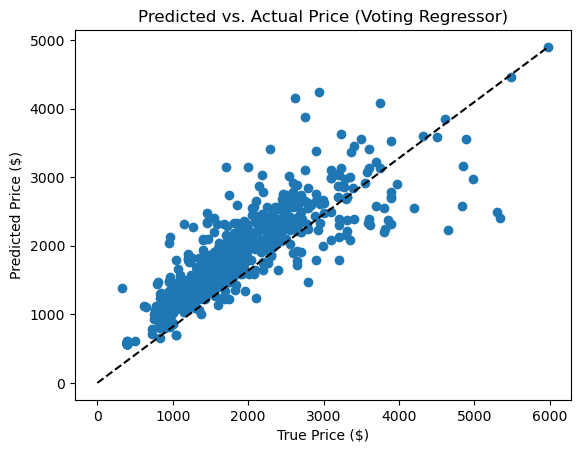

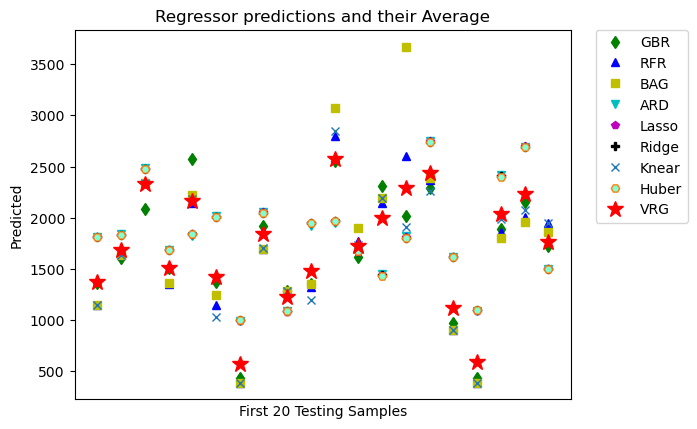

In [85]:
plt.figure()
plt.plot(gbr_pred[:20],'gd',label='GBR')
plt.plot(rfr_pred[:20],'b^',label='RFR')
plt.plot(bag_pred[:20],'ys',label='BAG')
plt.plot(ard_pred[:20],'cv',label='ARD')
plt.plot(lasso_pred[:20],'pm',label='Lasso')
plt.plot(ridge_pred[:20],'Pk',label='Ridge')
plt.plot(knn_pred[:20],'x',label='Knear')
plt.plot(huber_pred[:20],'H',markerfacecolor='aquamarine',label='Huber')
plt.plot(vrg.predict(X_test_scaled)[:20],'r*',label='VRG', markersize=12)

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("Predicted")
plt.xlabel("First 20 Testing Samples")
plt.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0)
plt.title("Regressor predictions and their Average")
plt.title("Regressor predictions and their Average")
# plt.savefig('figs/pred_vs_avg_with_city.png')
plt.show()